In [1]:
import pennylane as qml
import jax

from jax import numpy as np
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import matplotlib.pyplot as plt

from pennylane.wires import Wires
from functools import partial
from multiprocessing import Pool, cpu_count
from pathlib import Path
import pandas as pd
import pickle
import base64

import optax
from jax import config
import os
import jax
import time
import jax.numpy as jnp
from jax import jit, value_and_grad, vmap
import pennylane.numpy as pnp
#os.environ['OPENBLAS_NUM_THREADS'] = '1'
has_jax = True
diable_jit = True
config.update('jax_disable_jit', diable_jit)
#config.parse_flags_with_absl()
config.update("jax_enable_x64", True)
os.environ['JAX_TRACEBACK_FILTERING'] = 'off'

In [2]:
import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

def normalize(values):
    """Normalize a list of values to the range [0, 1]."""
    min_val = np.min(values)
    max_val = np.max(values)
    if min_val == max_val:
        return [0.5] * len(values)  # Return a constant value if all values are the same
    return [(v - min_val) / (max_val - min_val) for v in values]

def is_valid_pickle_file(file_path):
    """Check if a pickle file is valid."""
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                try:
                    pickle.load(f)
                    return True
                except EOFError:
                    print(f"File {file_path} is corrupted.")
                    return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False
def normalize(values):
    """Normalize a list of values to the range [0, 1]."""
    min_val = np.min(values)
    max_val = np.max(values)
    if min_val == max_val:
        return [0.5] * len(values)  # Return a constant value if all values are the same
    return [(v - min_val) / (max_val - min_val) for v in values]
def process_data_combined(df, threshold, by_test, N_R, trot, print_bool, weight_median=0.5, weight_iqr=0.5):
    """Load and process data from a pickle file."""
    
    max_eigvals = []
    trace_eigvals = []
    min_eigvals = []
    var_eigval = []
    ranks = []
    var_log_eigval, norm_trace_eigvals = [],[]
    ratios = []
    counts = []
    entropies = []
    qfim_eigval_list = []
    redundancies = []
    for fixed_params_dict in df.keys():
        for test in df[fixed_params_dict].keys():
            qfim_eigvals = df[fixed_params_dict][test]['qfim_eigvals']
            qfim_eigval_list.append(qfim_eigvals)
            n_params = len(qfim_eigvals)
            nonzero_eigvals = qfim_eigvals[qfim_eigvals > threshold]
            counts.append(len(nonzero_eigvals))
            num_nonzero_eigvals = len(nonzero_eigvals)
            ranks.append(num_nonzero_eigvals)
            ratios.append(num_nonzero_eigvals / n_params)
            redundancies.append((n_params-num_nonzero_eigvals)/n_params)
            var_eigval.append(np.var(nonzero_eigvals) if nonzero_eigvals.size > 0 else np.nan)
            var_log_eigval.append(np.var(np.log10(nonzero_eigvals)) if nonzero_eigvals.size > 0 else np.nan)
            trace_eigvals.append(np.sum(qfim_eigvals))
            norm_trace_eigvals.append(np.sum(qfim_eigvals)/len(nonzero_eigvals))
            max_eigvals.append(np.max(nonzero_eigvals) if nonzero_eigvals.size > 0 else np.nan)
            min_eigvals.append(np.min(nonzero_eigvals) if nonzero_eigvals.size > 0 else np.nan)
            # print(df[fixed_params_dict][test].keys())
            entropies.append(df[fixed_params_dict][test]['entropies'])
    
    mean_trace = np.mean(trace_eigvals)
    mean_norm_trace_eigvals = np.mean(norm_trace_eigvals)
    mean_var_eigval = np.mean(var_eigval)
    mean_var_log_eigval = np.mean(var_log_eigval)
    mean_entropy = np.mean(entropies)
    # Calculate the median and IQR
    median_trace = np.median(trace_eigvals)
    median_var_eigval = np.median(var_eigval)
    median_var_log_eigval = np.median(var_log_eigval)
    
    iqr_trace = iqr(trace_eigvals, rng= (10,90))
    iqr_var_eigval = iqr(var_eigval,  rng= (10,90))
    iqr_var_log_eigval = iqr(var_log_eigval, rng= (10,90))
    
    weighted_avg_trace = weight_median * median_trace + weight_iqr * iqr_trace
    weighted_avg_var_eigval = weight_median * median_var_eigval + weight_iqr * iqr_var_eigval
    weighted_avg_var_log_eigval = weight_median * median_var_log_eigval + weight_iqr * iqr_var_log_eigval

    
    return {
        'mean_trace_eigvals': np.mean(trace_eigvals),
        'mean_entropy':mean_entropy,
        'quantum_dim': np.mean(ranks),
        'ratios':np.mean(ratios),
        'redundancies':np.mean(redundancies),
        'mean_norm_trace_eigvals':mean_norm_trace_eigvals,
        'median_trace_eigvals': median_trace,
        'iqr_trace_eigvals': iqr_trace,
        'weighted_avg_trace_eigvals': weighted_avg_trace,
        'mean_var_eigval': np.mean(var_eigval),
        'median_var_eigval': median_var_eigval,
        'iqr_var_eigval': iqr_var_eigval,
        'weighted_avg_var_eigval': weighted_avg_var_eigval,
         'mean_var_log_eigval': np.mean(var_log_eigval),
        'median_var_log_eigval': median_var_log_eigval,
        'iqr_var_log_eigval': iqr_var_log_eigval,
        'weighted_avg_var_log_eigval': weighted_avg_var_log_eigval,
        'all_qfim_eigvals':qfim_eigval_list,
    }


In [6]:
import matplotlib.pyplot as plt
from scipy.stats import iqr
threshold = 1e-12
by_test = False
N_ctrls = [1,2,3]

base_state = 'GHZ_state'
base_path = Path('/Users/sophieblock/QRCCapstone/')

model_type = 'analog_model_DQFIM'

all_data = []
num_states_sampled=50

# Function to check if a file is a valid pickle file
def is_valid_pickle_file(file_path):
    return file_path.exists() and file_path.is_file()

# Function to check and skip hidden system files like .DS_Store
def is_hidden_file(file_name):
    return file_name.startswith('.')

for N_ctrl in N_ctrls:
    
    # Model path includes the '1xK' folder after the 'L_{num_states_sampled}'
    model_path = base_path / 'QFIM_traced_final_results' / model_type / f'Nc_{N_ctrl}' / f'L_{num_states_sampled}' / '1xK'
    
    # Print the model path being processed
    print(f"Processing model path: {model_path}")
    
    if not model_path.exists():
        print(f"Model path not found: {model_path}")
        continue
    
    for Nr in sorted(os.listdir(model_path)):
        if is_hidden_file(Nr):  # Skip hidden files
            continue
        Nr_path = model_path / Nr
        if not Nr_path.is_dir():
            print(f"Nr path not a directory: {Nr_path}")
            continue

        for trotter_step in sorted(os.listdir(Nr_path)):
            if is_hidden_file(trotter_step):  # Skip hidden files
                continue
            trotter_step_path = Nr_path / trotter_step
            if not trotter_step_path.is_dir():
                print(f"Trotter step path not a directory: {trotter_step_path}")
                continue

            # Now correctly pointing to nested L_{num_states_sampled} inside each trotter_step
            folder_gate = trotter_step_path / f'L_{num_states_sampled}'  

            data_file = folder_gate / 'data_pi.pickle'
            
            # Check if the pickle file exists and is valid
            if is_valid_pickle_file(data_file):
                print(f"Reading data from: {data_file}")
                with open(data_file, 'rb') as f:
                    df = pickle.load(f)
                    trotter_step_num = int(trotter_step.split('_')[-1])
                    processed_data = process_data_combined(df, threshold, by_test, int(Nr.split('_')[-1]), trotter_step_num, False)
                    processed_data.update({
                        'N_ctrl': N_ctrl,
                        'N_reserv': int(Nr.split('_')[-1]),
                        'Trotter_Step': trotter_step_num
                    })
                    all_data.append(processed_data)
            else:
                print(f"Data file not found or invalid: {data_file}")

# Convert the list of dictionaries to a DataFrame
if all_data:
    df_all = pd.DataFrame(all_data)
    print(df_all)
else:
    print("No data found.")
# /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/gate_model_DQFIM/Nc_2/L_100/1xK

Processing model path: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_1/L_50/1xK
Reading data from: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_1/L_50/1xK/Nr_1/trotter_step_1/L_50/data_pi.pickle


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_72723/3337289087.py:60: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  df = pickle.load(f)


Reading data from: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_1/L_50/1xK/Nr_1/trotter_step_2/L_50/data_pi.pickle
Reading data from: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_1/L_50/1xK/Nr_1/trotter_step_3/L_50/data_pi.pickle


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_72723/3337289087.py:60: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  df = pickle.load(f)
/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_72723/3337289087.py:60: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  df = pickle.load(f)


Reading data from: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_1/L_50/1xK/Nr_1/trotter_step_4/L_50/data_pi.pickle
Reading data from: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_1/L_50/1xK/Nr_1/trotter_step_5/L_50/data_pi.pickle


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_72723/3337289087.py:60: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  df = pickle.load(f)
/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_72723/3337289087.py:60: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  df = pickle.load(f)


Processing model path: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_2/L_50/1xK
Reading data from: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_2/L_50/1xK/Nr_1/trotter_step_1/L_50/data_pi.pickle
Reading data from: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_2/L_50/1xK/Nr_1/trotter_step_10/L_50/data_pi.pickle
Reading data from: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_2/L_50/1xK/Nr_1/trotter_step_11/L_50/data_pi.pickle
Reading data from: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_2/L_50/1xK/Nr_1/trotter_step_12/L_50/data_pi.pickle
Reading data from: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_2/L_50/1xK/Nr_1/trotter_step_13/L_50/data_pi.pickle
Reading data from: /Users/sophieblock/QRCCapstone/QFIM_traced_final_results/analog_model_DQFIM/Nc_2/L_50/1xK/Nr_1/trotter_step_14/L_50/dat

In [7]:
threshold = 1e-12

# Apply the condition where values below the threshold are set to 0, and then calculate the mean
df_all['avg_qfim_eigvals'] = df_all['all_qfim_eigvals'].apply(
    lambda x: np.mean(np.where(np.array(x) < threshold, 0, np.array(x)), axis=0)
)
# Choose a scaling factor alpha
alpha = 0.75  # sqrt, adjust this between 0 and 1 depending on how much scaling you want

# Apply the power law transformation
df_all['power_scaled_avg_qfim_eigvals'] = df_all['avg_qfim_eigvals'].apply(
    lambda avg_vals: np.array(avg_vals) ** alpha
)
df_all['power_scaled_avg_qfim_eigvals_nonzero'] = df_all['avg_qfim_eigvals'].apply(
    lambda avg_vals: np.array([val for val in avg_vals if val > threshold]) ** alpha
)
# # Now calculate the variance of the power-scaled values and store it in a new column
df_all['var_power_scaled_avg_qfim_eigvals'] = df_all['power_scaled_avg_qfim_eigvals'].apply(
    lambda scaled_vals: np.var(scaled_vals)
)
df_all['var_power_scaled_avg_qfim_eigvals_nonzero'] = df_all['power_scaled_avg_qfim_eigvals_nonzero'].apply(
    lambda scaled_vals: np.var(scaled_vals)
)
df_all.head()

,mean_trace_eigvals,mean_entropy,quantum_dim,ratios,redundancies,mean_norm_trace_eigvals,median_trace_eigvals,iqr_trace_eigvals,weighted_avg_trace_eigvals,mean_var_eigval,...,weighted_avg_var_log_eigval,all_qfim_eigvals,N_ctrl,N_reserv,Trotter_Step,avg_qfim_eigvals,power_scaled_avg_qfim_eigvals,power_scaled_avg_qfim_eigvals_nonzero,var_power_scaled_avg_qfim_eigvals,var_power_scaled_avg_qfim_eigvals_nonzero
0,7.580748,0.240623,2.99,0.598000,0.402000,2.526925,1.844245,23.748844,12.796545,43.334056,...,4.356050,"[[-3.9915720093998726e-18, 2.353500715762451e-...",1,1,1,"[0.0, 0.0, 0.0001681886851344916, 0.0024021598...","[0.0, 0.0, 0.0014768880671189011, 0.0108505417...","[0.0014768880671189011, 0.010850541747972876, ...",3.333366,4.623417
1,14.695729,0.262635,3.00,0.428571,0.571429,4.898576,10.482473,36.141355,23.311914,96.944244,...,1.922830,"[[-1.0287672667281393e-15, 1.340962351173196e-...",1,1,2,"[0.0, 0.0, 0.0, 0.0, 0.010538350112516838, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.03289118096391636, 0.24...","[0.03289118096391636, 0.24533901062751598, 7.4...",6.705708,11.861636
2,27.906956,0.295085,3.00,0.333333,0.666667,9.302319,18.689521,68.460243,43.574882,339.317910,...,1.804998,"[[-3.4011380424724366e-15, -1.3735594339740598...",1,1,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0285997302454...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0695458873330...","[0.06954588733300987, 0.41077744528745663, 12....",14.173565,30.922496
3,41.382918,0.299123,3.00,0.272727,0.727273,13.794306,29.772127,83.537007,56.654567,661.455885,...,2.342709,"[[-1.1616524663296781e-15, -4.360755538400907e...",1,1,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.057...","[0.05751104551674353, 0.34348369455560984, 16....",21.694062,57.171813
4,49.550950,0.314149,3.00,0.230769,0.769231,16.516983,35.686108,96.788072,66.237090,913.818470,...,1.513629,"[[-9.146956919975398e-16, -5.843836704489371e-...",1,1,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2815130387224749, 1.276613635752728, 18.230...",23.380615,67.845761


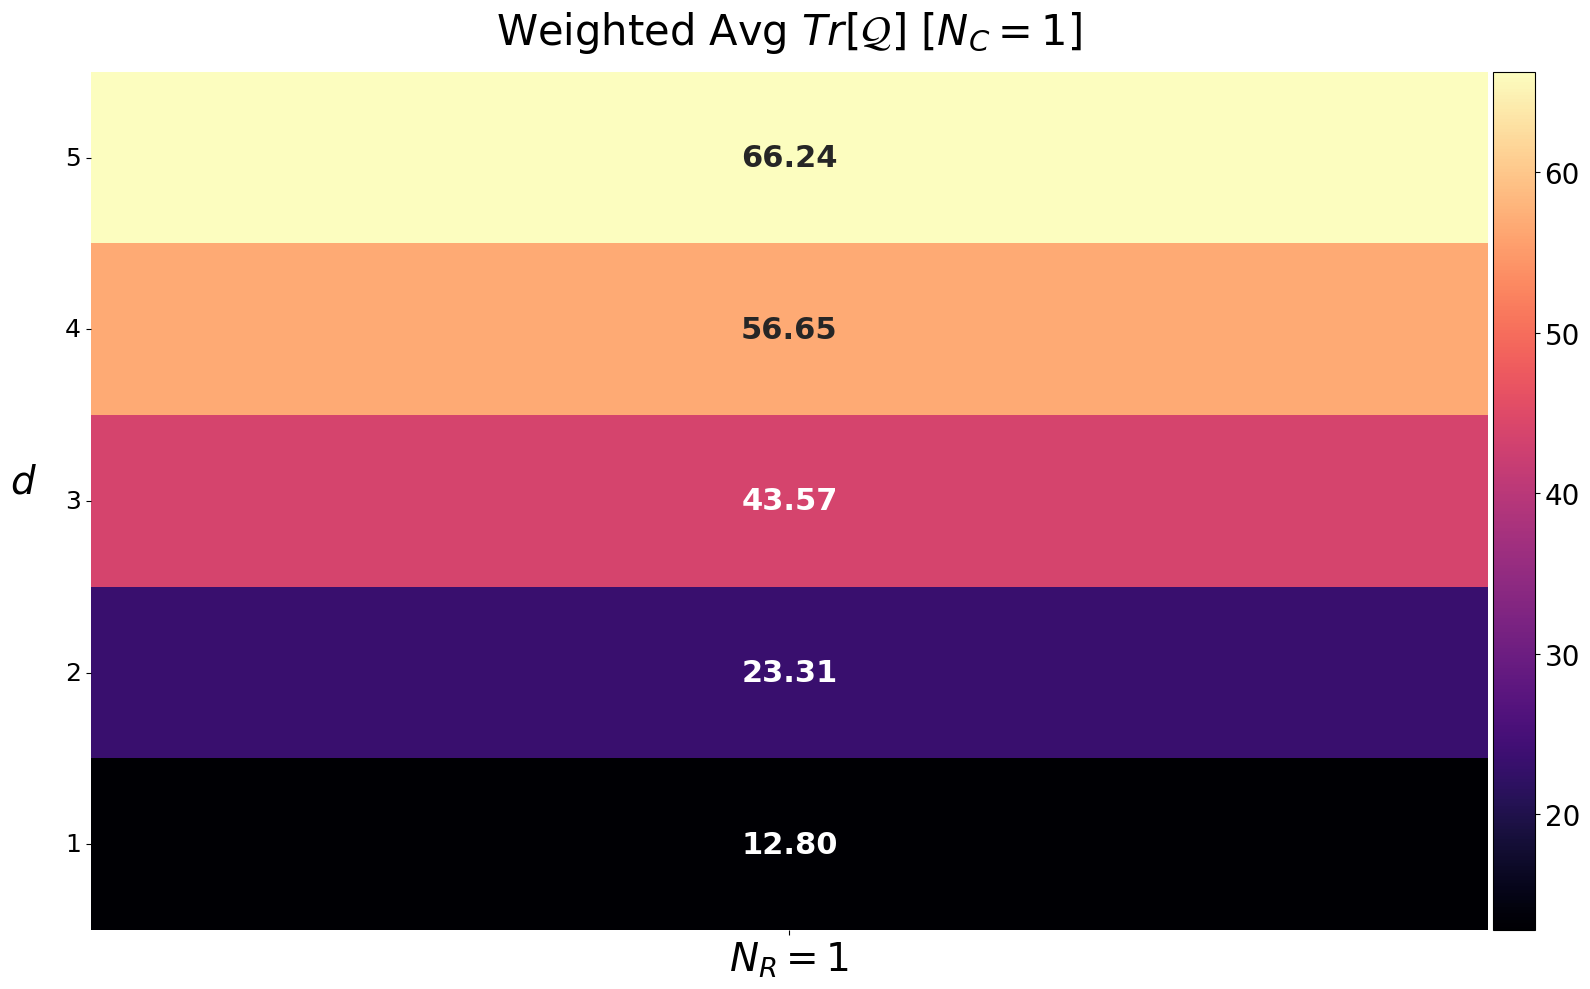

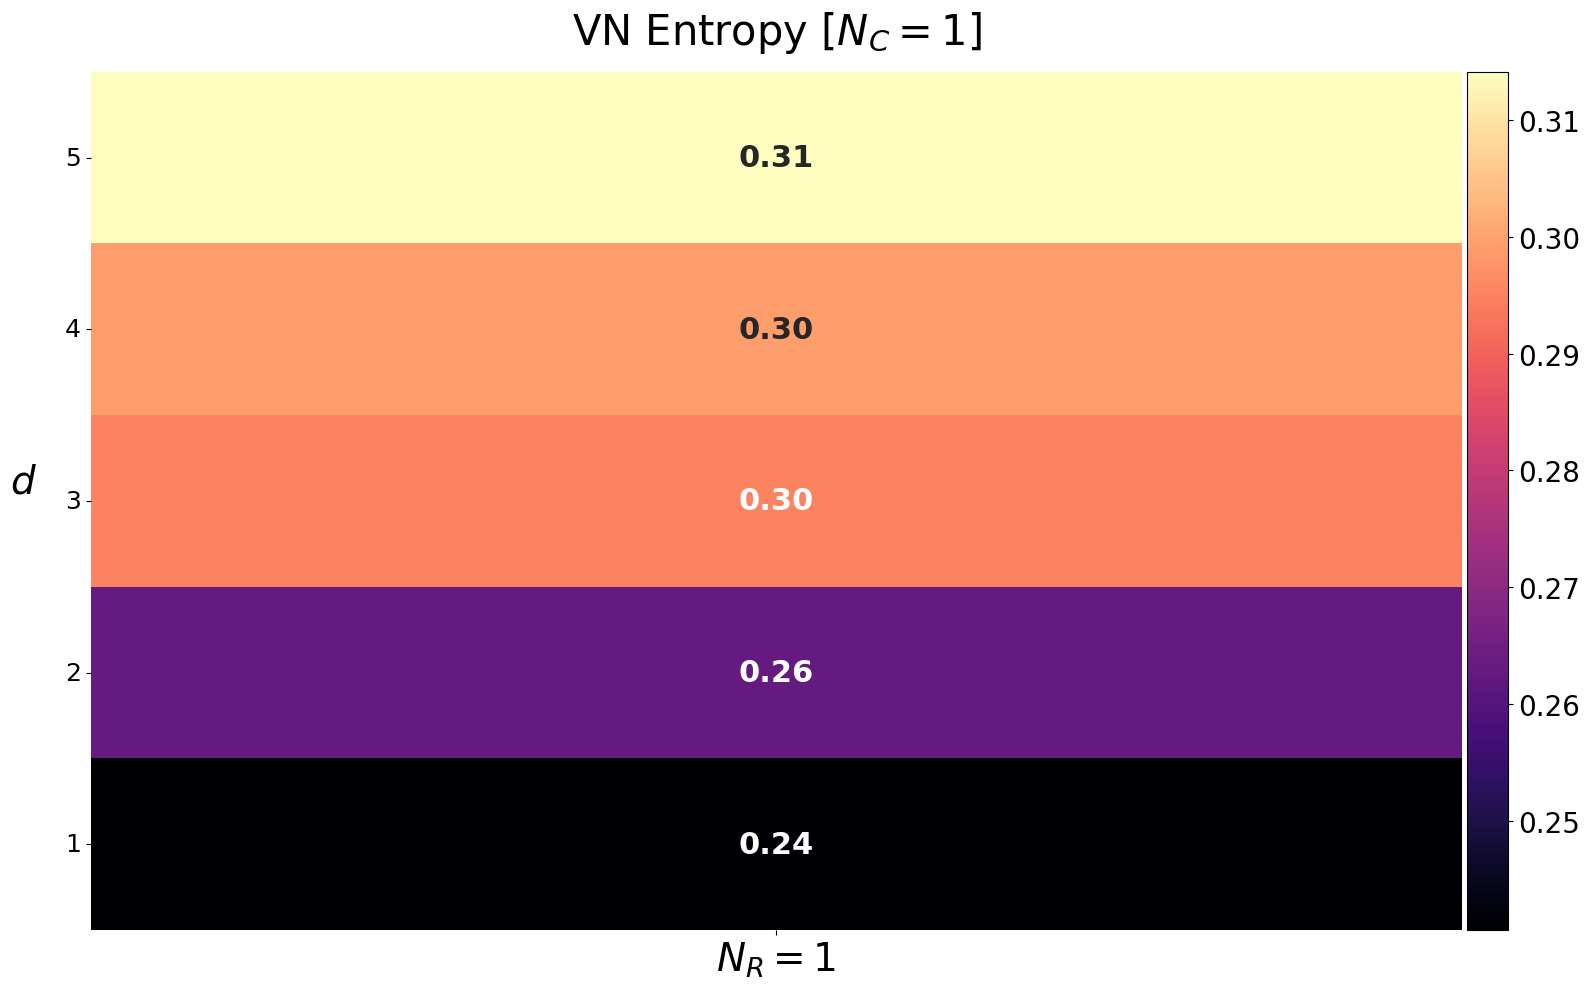

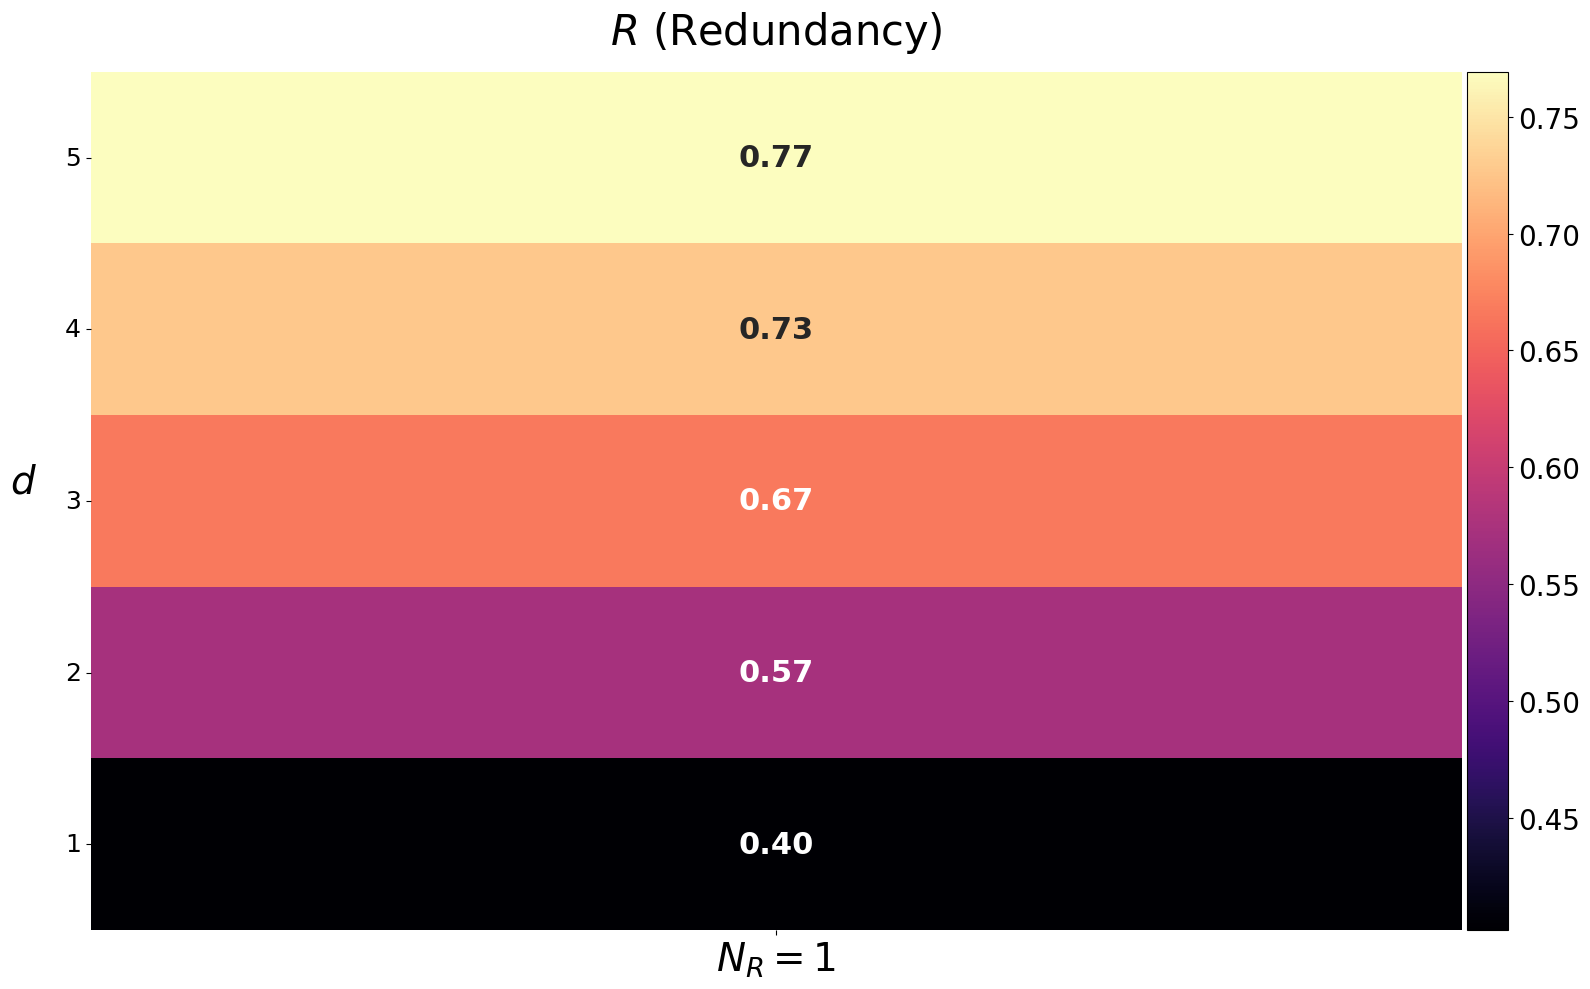

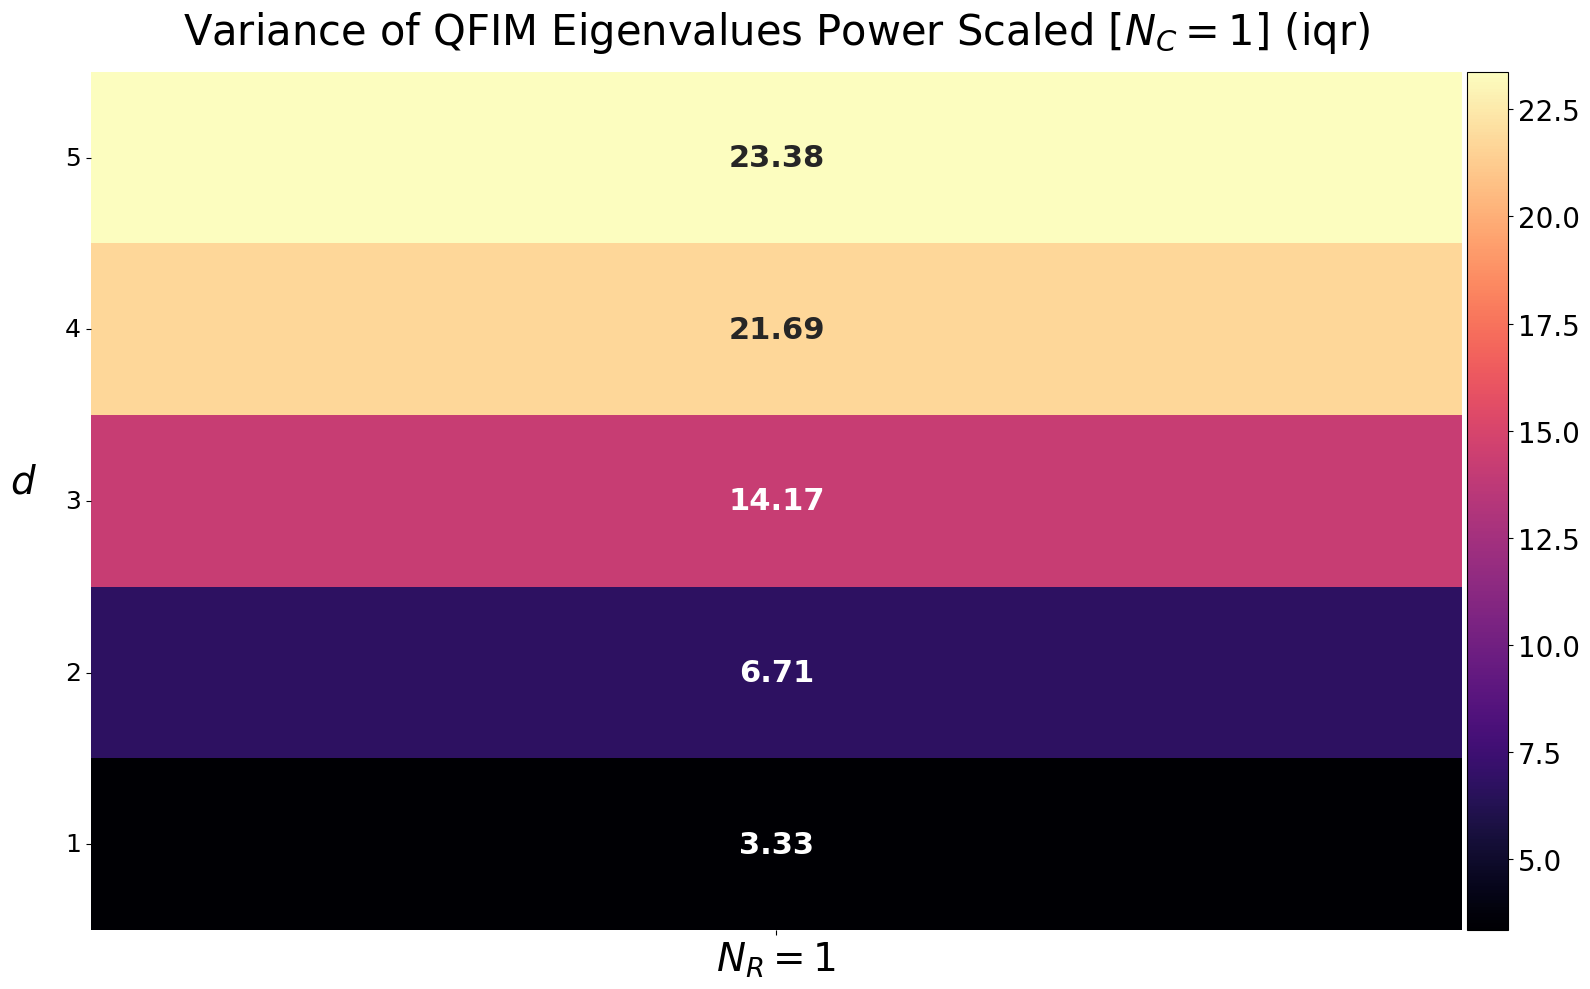

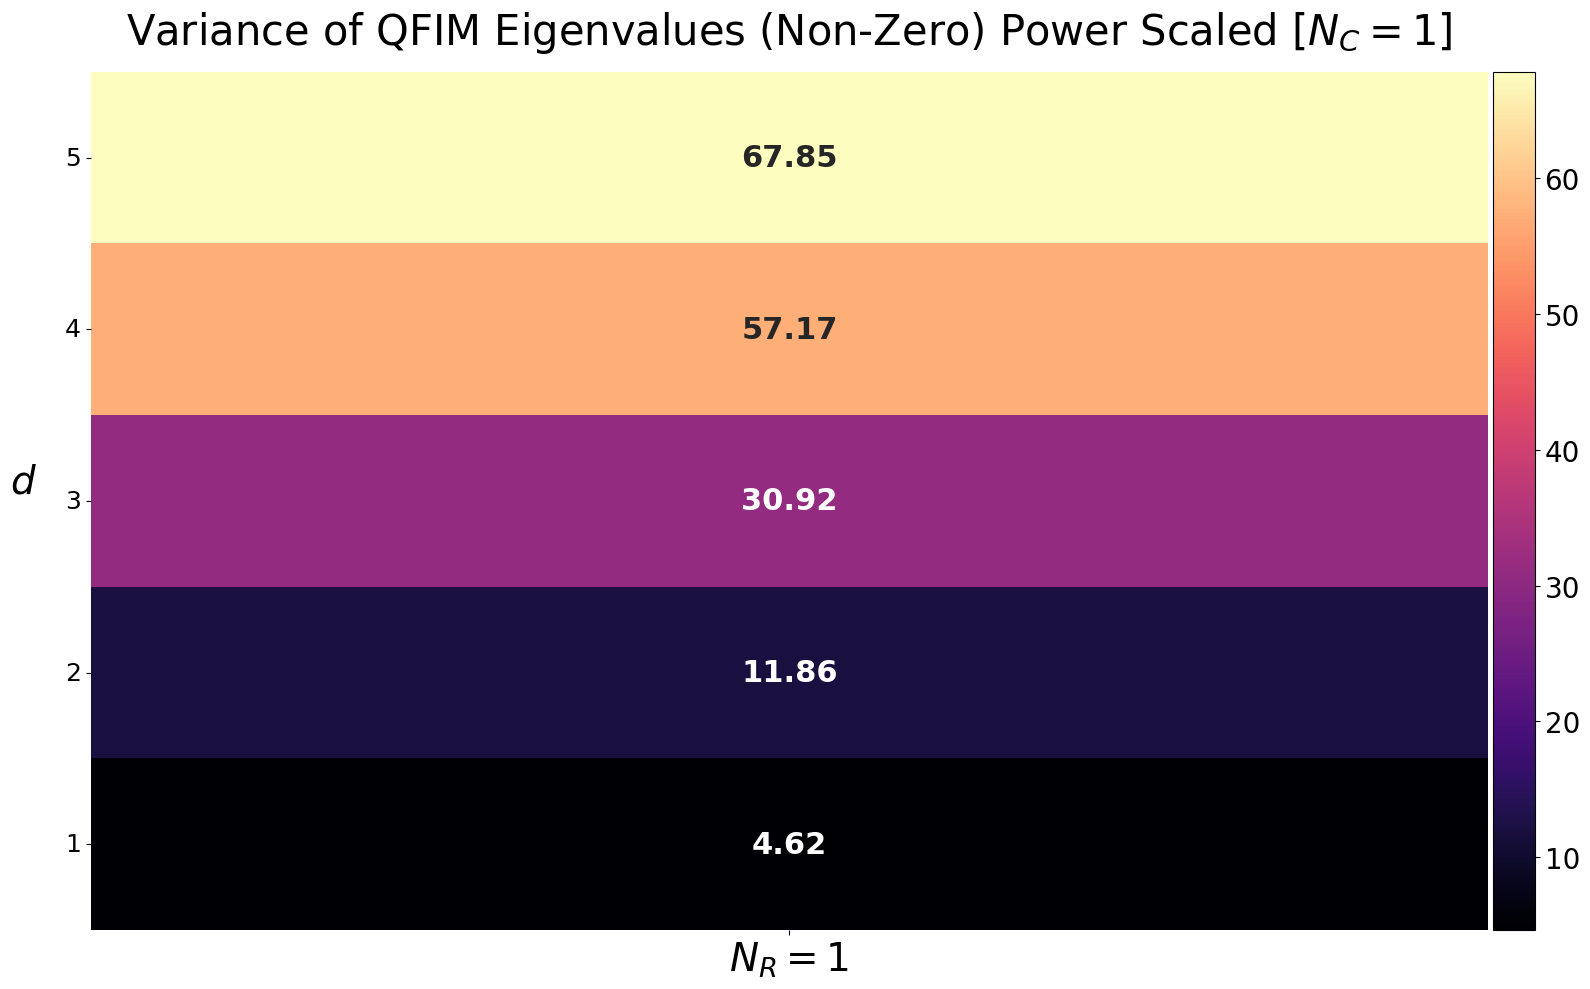

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_ctrl = 1
metric_keys = ['weighted_avg_trace_eigvals', 'mean_entropy',  'redundancies','var_power_scaled_avg_qfim_eigvals', 'var_power_scaled_avg_qfim_eigvals_nonzero']
metrics_info = {
    'weighted_avg_trace_eigvals': {
        'title': f'Weighted Avg ${{Tr}}[\mathcal{{Q}}]$ [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'quantum_dim': {
        'title': f'$G_C$ (Rank) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'mean_entropy': {
        'title': f'VN Entropy [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'redundancies': {
        'title': f'$R$ (Redundancy)',
        'cbar': ''
    },
    'var_power_scaled_avg_qfim_eigvals': {
        'title': f'Variance of QFIM Eigenvalues Power Scaled [$N_C = {N_ctrl}$] (iqr)',
        'cbar': ''
    },
    'var_power_scaled_avg_qfim_eigvals_nonzero': {
        'title': f'Variance of QFIM Eigenvalues (Non-Zero) Power Scaled [$N_C = {N_ctrl}$]',
        'cbar': ''
    }
}

# resies = [1]
resies = [1, 2 ,3]

for metric_key in metric_keys:
    # Retrieve title and color bar from the dictionary
    metric_title = metrics_info[metric_key]['title']
    metric_cbar = metrics_info[metric_key]['cbar']
    # Filter the data for the current N_ctrl
    df_filtered = df_all[df_all['N_ctrl'] == N_ctrl][['N_reserv', 'Trotter_Step', f'{metric_key}']]
    
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        trots = [1, 2, 3, 4, 5]
    elif N_ctrl == 2:
        trots = [1, 3,4,5, 6,7, 8,9, 10, 12, 14, 16, 18, 20, 22, 24]
    else:
        trots = np.arange(1, 45, 1)
    
    df_filtered = df_filtered[df_filtered['Trotter_Step'].isin(trots)]
    df_filtered = df_filtered[df_filtered['N_reserv'].isin(resies)]
    
    # Aggregate the data by Trotter_Step and N_reserv
    df_heatmap = df_filtered.groupby(['Trotter_Step', 'N_reserv']).agg({metric_key: 'mean'}).reset_index()
    
    # Pivot the data to create a heatmap
    heatmap_pivot = df_heatmap.pivot(index='Trotter_Step', columns='N_reserv', values=metric_key)
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(16, 10))

    # Disable the default color bar by setting `cbar=False`
    sns.heatmap(heatmap_pivot, ax=ax, cmap='magma', annot=True, fmt=".2f", annot_kws={"size": 22,"weight":'bold',}, cbar=False)

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)  # Adjust pad for proximity

    # Create a manual color bar
    cbar = fig.colorbar(ax.collections[0], cax=cax)
    cbar.set_label(metric_cbar, rotation=0, labelpad=20, fontsize=22, weight="bold")
    cbar.ax.tick_params(labelsize=20)

    ax.invert_yaxis()
    ax.set_title(metric_title, fontsize=30, pad=20)
    ax.set_ylabel('$d$', labelpad=30, fontsize=28, rotation=0)
    ax.set_xlabel('', fontsize=20)
    ax.tick_params(axis='y', labelrotation=0, labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.set_xticklabels([f'$N_R = {rc+1}$' for rc in range(len(ax.get_xticklabels()))], fontweight='bold', fontsize=28, rotation=0)
    
    plt.tight_layout()
    plt.show()


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_72723/1805913822.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[expressivity_metric] = normalize(df_filtered[expressivity_metric])
/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_72723/1805913822.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[complexity_metric] = normalize(df_filtered[complexity_metric])


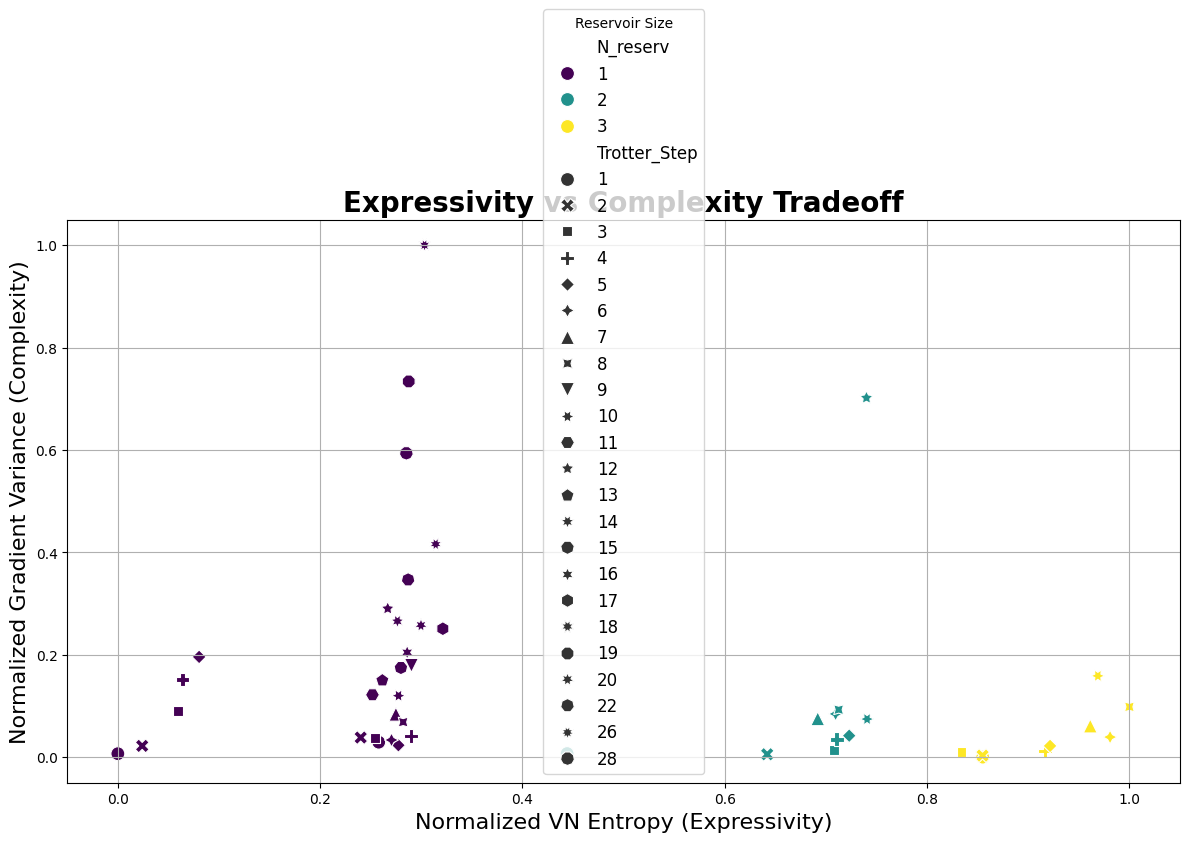

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to normalize data
def normalize(values):
    """Normalize a list of values to the range [0, 1]."""
    min_val = np.min(values)
    max_val = np.max(values)
    return [(v - min_val) / (max_val - min_val) if max_val != min_val else 0.5 for v in values]

# Sample data preparation: Replace this with your real data
# Assuming df_all contains the processed data from your main loop
expressivity_metric = 'mean_entropy'  # Expressivity: VN entropy
complexity_metric = 'weighted_avg_var_eigval'  # Complexity: Gradient variance, training difficulty

# Filter data and normalize
df_filtered = df_all[['N_reserv', 'Trotter_Step', expressivity_metric, complexity_metric]]
# df_filtered[expressivity_metric] = normalize(df_filtered[expressivity_metric])
# df_filtered[complexity_metric] = normalize(df_filtered[complexity_metric])

# Plot: Expressivity vs Complexity
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=df_filtered[expressivity_metric],
    y=df_filtered[complexity_metric],
    hue=df_filtered['N_reserv'],  # Color by reservoir size
    style=df_filtered['Trotter_Step'],  # Style by trotter step
    palette="viridis",
    s=100
)

plt.title('Expressivity vs Complexity Tradeoff', fontsize=20, weight='bold')
plt.xlabel('Normalized VN Entropy (Expressivity)', fontsize=16)
plt.ylabel('Normalized Gradient Variance (Complexity)', fontsize=16)
plt.legend(title='Reservoir Size', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


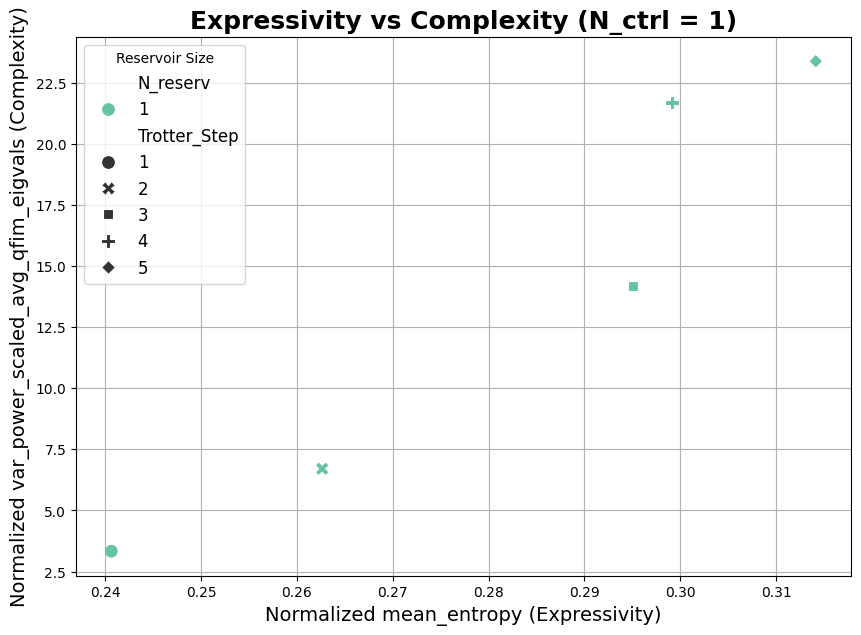

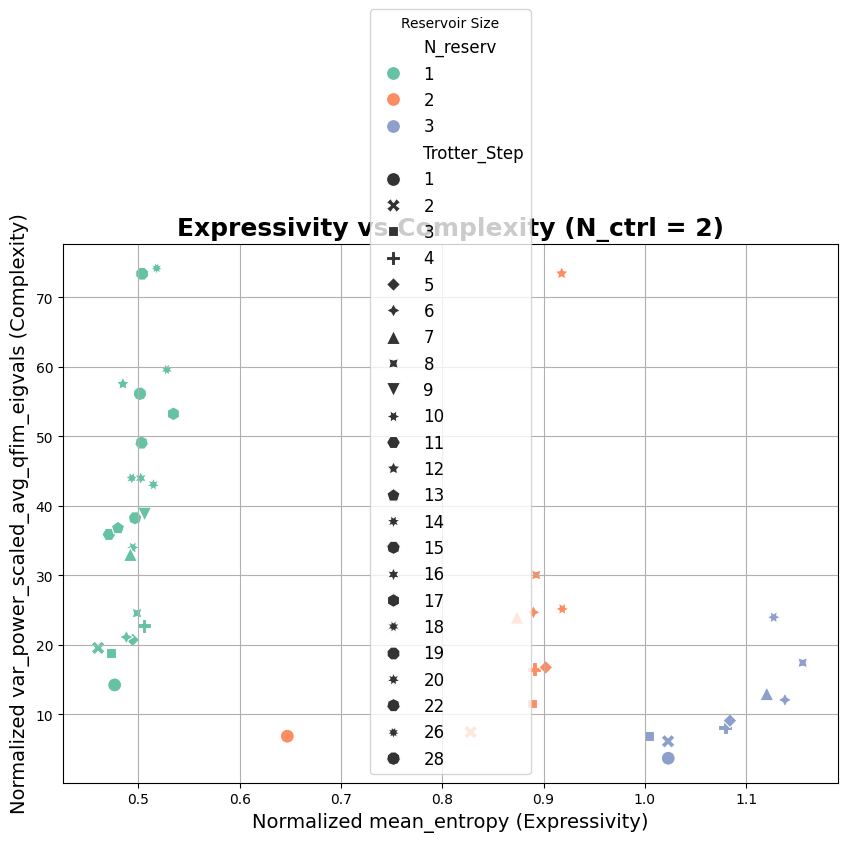

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_72723/251819358.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


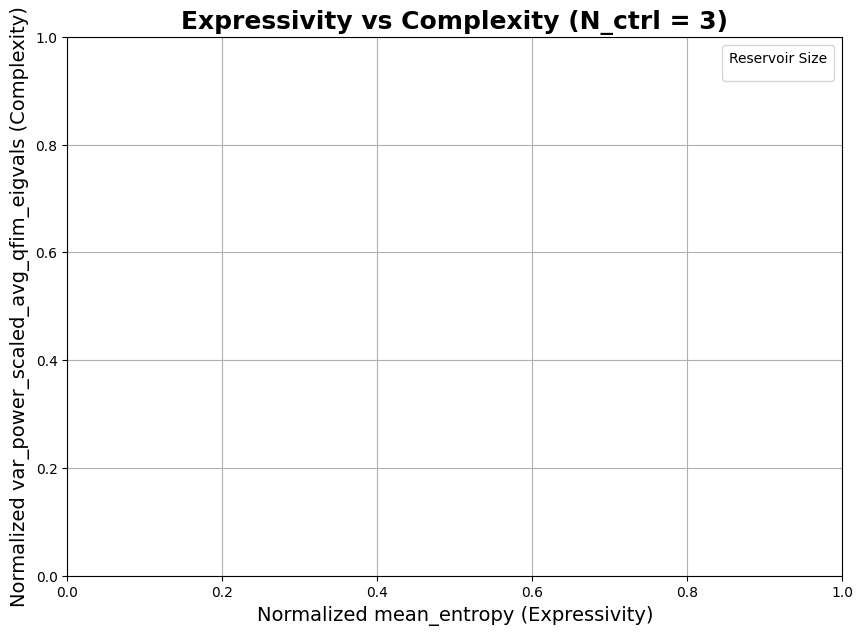

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_expressivity_complexity(df_all, N_ctrl_values, x_metric, y_metric):
    """
    Generate scatter plots for expressivity vs complexity for different N_ctrl values.
    
    Parameters:
    df_all: DataFrame containing processed data
    N_ctrl_values: List of N_ctrl values to filter by
    x_metric: Column name representing expressivity (e.g., normalized VN entropy)
    y_metric: Column name representing complexity (e.g., normalized gradient variance)
    """
    for N_ctrl in N_ctrl_values:
        # Filter data for current N_ctrl

        
        df_filtered = df_all[df_all['N_ctrl'] == N_ctrl]
        
        plt.figure(figsize=(10, 7))
        sns.scatterplot(
            x=x_metric,
            y=y_metric,
            hue='N_reserv',
            style='Trotter_Step',
            data=df_filtered,
            s=100,  # Adjust size for visibility
            palette='Set2'
        )
        
        plt.title(f"Expressivity vs Complexity (N_ctrl = {N_ctrl})", fontsize=18, fontweight='bold')
        plt.xlabel(f"Normalized {x_metric} (Expressivity)", fontsize=14)
        plt.ylabel(f"Normalized {y_metric} (Complexity)", fontsize=14)
        plt.legend(title='Reservoir Size', fontsize=12)
        plt.grid(True)
        plt.show()

# Example usage
plot_expressivity_complexity(
    df_all=df_all,  # Use your DataFrame here
    N_ctrl_values=[1, 2, 3],
    x_metric='mean_entropy',  # Adjust for your normalized expressivity metric
    y_metric='var_power_scaled_avg_qfim_eigvals'  # Adjust for your complexity metric
)


